# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [3]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [4]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

[autoreload of prompt_toolkit failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/opt/conda/lib/python3.6/site-packages/prompt_toolkit/__init__.py", line 18, in <module>
    from .shortcuts import PromptSession, prompt, print_formatted_text
ImportError: cannot import name 'PromptSession'
]
[autor

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
print('brain name: {}'.format(brain_name))
print()
print('action space      - size: {:2d} \t(type: {})'.format(brain.vector_action_space_size, brain.vector_action_space_type))
print('observation space - size: {:2d} \t(type: {})'.format(brain.vector_observation_space_size, brain.vector_observation_space_type))

brain name: BananaBrain

action space      - size:  4 	(type: discrete)
observation space - size: 37 	(type: continuous)


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Double DQN

The implementation is based on [van Hasselt](https://arxiv.org/abs/1509.06461)'s work.

#### Eps start = 1.0, Eps decay = 0.995

In [21]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.ddqn_agent import DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='ddqn'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model=dir_models + filename_model





if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)

if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def ddqn(unity_env, path_model, path_log, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE):
    task = Task(unity_env=unity_env)
    agent = DDQN_Agent(task.state_size, task.action_size, seed=seed)

    # Main body of traininig
    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    

    time_start = datetime.now()

    for i_episode in range(1, n_episodes+1):
        
        state = task.reset()
        score = 0.0

        for t in range(max_t):

            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break


        scores_window.append(score)
        scores.append(score)
        
        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # print training message
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode,
                                                                               np.mean(scores_window),
                                                                               datetime.now() - time_start))

            time_start = datetime.now()


        # endding crietrion
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            break


    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)
    
    return scores
    

scores = ddqn(unity_env=env, path_model=path_model, path_log=path_log, n_episodes=n_episodes)

# save scores
with open(path_log, 'wb') as f:
    pickle.dump(scores, f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode 100	Average Score: 0.26, execution time=0:01:40.682906
Episode 200	Average Score: 4.10, execution time=0:01:41.216211
Episode 300	Average Score: 8.13, execution time=0:01:44.941720
Episode 400	Average Score: 10.05, execution time=0:01:48.569683
Episode 498	 Average Score: 13.01
Environment solved in 398 episodes!	Average Score: 13.01


#### Eps start = 1.0, Eps decay = 0.995

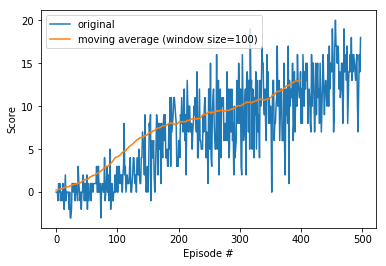

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle

def plot_result(path_log, length_moving_average):
    with open(path_log, 'rb') as f:
        scores = pickle.load(f)

    moving_average = np.convolve(scores, np.ones((length_moving_average,))/length_moving_average, mode='valid')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='original')
    plt.plot(np.arange(len(moving_average)), moving_average, label='moving average (window size={})'.format(length_moving_average))
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

plot_result(path_log, LENGTH_MOVING_AVERAGE)


### Starting Epsilon = 0.98


In [23]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.ddqn_agent import DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='ddqn_eps098'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model=dir_models + filename_model





if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)

if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def ddqn(unity_env, path_model, path_log, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE):
    task = Task(unity_env=unity_env)
    agent = DDQN_Agent(task.state_size, task.action_size, seed=seed)

    # Main body of traininig
    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    

    time_start = datetime.now()

    for i_episode in range(1, n_episodes+1):
        
        state = task.reset()
        score = 0.0

        for t in range(max_t):

            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break


        scores_window.append(score)
        scores.append(score)
        
        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # print training message
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode,
                                                                               np.mean(scores_window),
                                                                               datetime.now() - time_start))

            time_start = datetime.now()


        # endding crietrion
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            break


    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)
    
    return scores
    

scores = ddqn(eps_start=0.98, unity_env=env, path_model=path_model, path_log=path_log, n_episodes=n_episodes)

# save scores
with open(path_log, 'wb') as f:
    pickle.dump(scores, f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode 100	Average Score: 0.89, execution time=0:01:41.830116
Episode 200	Average Score: 4.77, execution time=0:01:41.790515
Episode 300	Average Score: 8.02, execution time=0:01:47.927658
Episode 400	Average Score: 10.31, execution time=0:01:50.090371
Episode 479	 Average Score: 13.05
Environment solved in 379 episodes!	Average Score: 13.05


#### Eps start = 1.0, Eps decay = 0.98

In [24]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.ddqn_agent import DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='ddqn_epsDecay_098'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model=dir_models + filename_model





if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)

if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def ddqn(unity_env, path_model, path_log, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE):
    task = Task(unity_env=unity_env)
    agent = DDQN_Agent(task.state_size, task.action_size, seed=seed)

    # Main body of traininig
    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    

    time_start = datetime.now()

    for i_episode in range(1, n_episodes+1):
        
        state = task.reset()
        score = 0.0

        for t in range(max_t):

            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break


        scores_window.append(score)
        scores.append(score)
        
        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # print training message
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode,
                                                                               np.mean(scores_window),
                                                                               datetime.now() - time_start))

            time_start = datetime.now()


        # endding crietrion
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            break


    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)
    
    return scores
    

scores = ddqn(eps_decay=0.98, unity_env=env, path_model=path_model, path_log=path_log, n_episodes=n_episodes)

# save scores
with open(path_log, 'wb') as f:
    pickle.dump(scores, f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode 100	Average Score: 2.75, execution time=0:01:42.919188
Episode 200	Average Score: 7.37, execution time=0:01:45.427724
Episode 300	Average Score: 10.43, execution time=0:01:46.166582
Episode 381	 Average Score: 13.03
Environment solved in 281 episodes!	Average Score: 13.03


#### Eps start = 1.0, Eps decay = 0.98

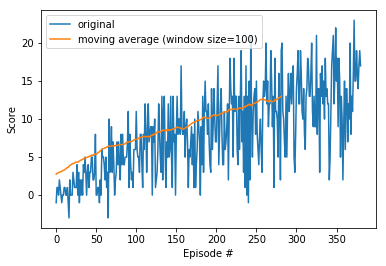

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle

def plot_result(path_log, length_moving_average):
    with open(path_log, 'rb') as f:
        scores = pickle.load(f)

    moving_average = np.convolve(scores, np.ones((length_moving_average,))/length_moving_average, mode='valid')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='original')
    plt.plot(np.arange(len(moving_average)), moving_average, label='moving average (window size={})'.format(length_moving_average))
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

plot_result(path_log, LENGTH_MOVING_AVERAGE)


#### Eps start = 1.0, Eps end = 0.02, Eps decay = 0.98 

In [26]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.ddqn_agent import DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='ddqn_epsEnd_002_epsDecay_098'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model=dir_models + filename_model





if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)

if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def ddqn(unity_env, path_model, path_log, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE):
    task = Task(unity_env=unity_env)
    agent = DDQN_Agent(task.state_size, task.action_size, seed=seed)

    # Main body of traininig
    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    

    time_start = datetime.now()

    for i_episode in range(1, n_episodes+1):
        
        state = task.reset()
        score = 0.0

        for t in range(max_t):

            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break


        scores_window.append(score)
        scores.append(score)
        
        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # print training message
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode,
                                                                               np.mean(scores_window),
                                                                               datetime.now() - time_start))

            time_start = datetime.now()


        # endding crietrion
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            break


    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)
    
    return scores
    

scores = ddqn(eps_end=0.02, eps_decay=0.98, unity_env=env, path_model=path_model, path_log=path_log, n_episodes=n_episodes)

# save scores
with open(path_log, 'wb') as f:
    pickle.dump(scores, f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode 100	Average Score: 1.26, execution time=0:01:41.972031
Episode 200	Average Score: 5.93, execution time=0:01:45.325273
Episode 300	Average Score: 11.43, execution time=0:01:48.625124
Episode 361	 Average Score: 13.05
Environment solved in 261 episodes!	Average Score: 13.05


#### Eps start = 1.0, Eps end = 0.02, Eps decay = 0.98 

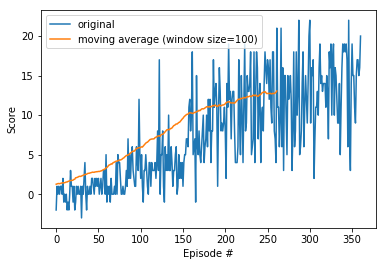

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle

def plot_result(path_log, length_moving_average):
    with open(path_log, 'rb') as f:
        scores = pickle.load(f)

    moving_average = np.convolve(scores, np.ones((length_moving_average,))/length_moving_average, mode='valid')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='original')
    plt.plot(np.arange(len(moving_average)), moving_average, label='moving average (window size={})'.format(length_moving_average))
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

plot_result(path_log, LENGTH_MOVING_AVERAGE)


#### Eps start = 1.0, Eps end = 0.1, Eps decay = 0.98 

In [6]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.ddqn_agent import DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='ddqn_epsEnd_01_epsDecay_098'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model=dir_models + filename_model





if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)

if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def ddqn(unity_env, path_model, path_log, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE):
    task = Task(unity_env=unity_env)
    agent = DDQN_Agent(task.state_size, task.action_size, seed=seed)

    # Main body of traininig
    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    

    time_start = datetime.now()

    for i_episode in range(1, n_episodes+1):
        
        state = task.reset()
        score = 0.0

        for t in range(max_t):

            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break


        scores_window.append(score)
        scores.append(score)
        
        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # print training message
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode,
                                                                               np.mean(scores_window),
                                                                               datetime.now() - time_start))

            time_start = datetime.now()


        # endding crietrion
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            break


    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)
    
    return scores
    

scores = ddqn(eps_end=0.1, eps_decay=0.98, unity_env=env, path_model=path_model, path_log=path_log, n_episodes=n_episodes)

# save scores
with open(path_log, 'wb') as f:
    pickle.dump(scores, f)

Episode 100	Average Score: 1.70, execution time=0:01:40.944018
Episode 200	Average Score: 7.77, execution time=0:01:41.249343
Episode 300	Average Score: 11.51, execution time=0:01:45.687765
Episode 361	 Average Score: 13.01
Environment solved in 261 episodes!	Average Score: 13.01


#### Eps start = 1.0, Eps end = 0.1, Eps decay = 0.98 

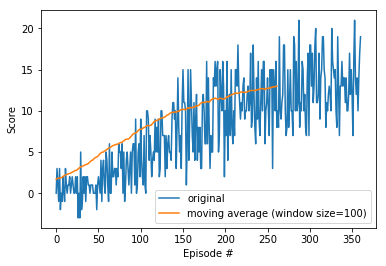

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle

def plot_result(path_log, length_moving_average):
    with open(path_log, 'rb') as f:
        scores = pickle.load(f)

    moving_average = np.convolve(scores, np.ones((length_moving_average,))/length_moving_average, mode='valid')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='original')
    plt.plot(np.arange(len(moving_average)), moving_average, label='moving average (window size={})'.format(length_moving_average))
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

plot_result(path_log, LENGTH_MOVING_AVERAGE)

#### Freerun - Eps start = 1.0, Eps end = 0.02, Eps decay = 0.98 

In [5]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.ddqn_agent import DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='ddqn_free_run_epsEnd_002_epsDecay_098'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model=dir_models + filename_model





if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)

if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def ddqn(unity_env, path_model, path_log, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE):
    task = Task(unity_env=unity_env)
    agent = DDQN_Agent(task.state_size, task.action_size, seed=seed)

    # Main body of traininig
    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    

    time_start = datetime.now()

    for i_episode in range(1, n_episodes+1):
        
        state = task.reset()
        score = 0.0

        for t in range(max_t):

            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break


        scores_window.append(score)
        scores.append(score)
        
        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # print training message
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode,
                                                                               np.mean(scores_window),
                                                                               datetime.now() - time_start))

            time_start = datetime.now()


        # endding crietrion
#         if np.mean(scores_window) >= 13.0:
#             print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
#             break


    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)
    
    return scores
    

scores = ddqn(eps_end=0.02, eps_decay=0.98, unity_env=env, path_model=path_model, path_log=path_log, n_episodes=n_episodes)

# save scores
with open(path_log, 'wb') as f:
    pickle.dump(scores, f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode 100	Average Score: 2.66, execution time=0:01:51.210975
Episode 200	Average Score: 7.23, execution time=0:01:41.550312
Episode 300	Average Score: 11.21, execution time=0:01:42.544221
Episode 400	Average Score: 14.18, execution time=0:01:45.539765
Episode 500	Average Score: 15.96, execution time=0:02:00.652662
Episode 600	Average Score: 16.25, execution time=0:01:47.430334
Episode 700	Average Score: 15.53, execution time=0:01:45.380746
Episode 800	Average Score: 15.84, execution time=0:01:49.702808
Episode 900	Average Score: 15.97, execution time=0:01:46.141042
Episode 1000	Average Score: 16.04, execution time=0:01:52.972063
Episode 1100	Average Score: 16.10, execution time=0:01:46.802585
Episode 1200	Average Score: 15.79, execution time=0:01:48.962137
Episode 1300	Average Score: 16.51, execution time=0:01:54.004949
Episode 1400	Average Score: 16.26, execution time=0:01:47.047225
Episode 1500	

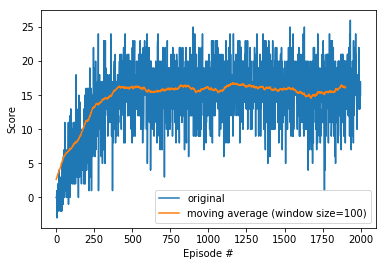

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle

def plot_result(path_log, length_moving_average):
    with open(path_log, 'rb') as f:
        scores = pickle.load(f)

    moving_average = np.convolve(scores, np.ones((length_moving_average,))/length_moving_average, mode='valid')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='original')
    plt.plot(np.arange(len(moving_average)), moving_average, label='moving average (window size={})'.format(length_moving_average))
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

plot_result(path_log, LENGTH_MOVING_AVERAGE)